# Ungraded Lab:  Multiclass Classification: One-vs-all

One vs All is one method for selection when there are more than two categories.
![pic](./figures/onevsmany.png)

# Outline
- [Tools](#tools)
- [Dataset](#dataset)
- [One vs All Implementation](#ova)



# Multiclass Classification: One-vs-all (OVA)
In this lab, we will explore how to use the One-vs-All method for classification when there are more than two categories.This technique is an extention of two class or binomial logistic regression that we have working with. 

In binomail logistic regression, we train a model to classify samples that are in a class or not in a class. One-vs-All(OVA) extends this method by training $n$ models. Each model is responsible for identifying one class. A model for a given class is trained by recasting the training set to identify one class as positive and all the rest as negative. To make predictions, an example is processed by all $n$ models and the model with the largest prediction output is selected.

In this lab, we will build a OVA classifier.
## Tools 
- We will utilize our previous work to build and train models. These routines are provided. 
- Plotting decision boundaries and datasets is helpful. Producing these plots is quite involved so helper routines are provided below.
- We will create a multi-class data set. Popular [`SkLearn`](https://scikit-learn.org/stable/) routines are utilized.

In [1]:
from lab_utils import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

In [2]:
# Plot  multi-class training points
def plot_mc_data(X, y, class_labels=None, legend=False):
    classes = np.unique(y)
    for i in classes:
        label = class_labels[i] if class_labels else "class {}".format(i)
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1],  cmap=plt.cm.Paired,
                    edgecolor='black', s=20, label=label)
    if legend: plt.legend()

These routines are provided but reviewing their operation is instructive. Plotting routines often make use of many esoteric but useful numpy routines. Plotting decision boundaries makes use of `matplotlib's` contour plot. A contour plot draws a line at boundary of a change in values. That capability is used to delineate changes in decisions. Briefly, the routine has 3 steps:
- create a fine mesh of locations in a 2-D grid. Build an array of those points.
- make predictions for each of those points. In this case, this includes the vote for the best prediction.
- plot the mesh vs the predictions(`Z`) using a contour plot.

In [3]:
#Plot a multi-class decision boundary
def plot_mc_decision_boundary(X,nclasses, Models , class_labels=None, legend=False):

    # create a mesh to points to plot
    h = 0.1  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]

    #make predictions for each point in mesh
    z = np.zeros((len(points),nclasses))
    Z = predict_mc(points,Models)
    Z = Z.reshape(xx.shape)

    #contour plot highlights boundaries between values - classes in this case
    plt.figure()
    plt.contour(xx, yy, Z, colors='g') 
    plt.axis('tight')


We're providing the routines which you have developed in previous labs to create and fit/train a model. Feel free to replace these with your own versions. (Keep a copy of the original just in case.)

In [4]:
def compute_gradient(X, y, w):
    
    m, n = X.shape
    f = sigmoid(np.matmul(X, w))
    dw = (1/m)*np.matmul(X.T, (f - y))

    return dw

In [5]:
def compute_cost(X, y, w):
    m = X.shape[0]
    
    f = sigmoid(X @ w)
    total_cost = (1/m)*(np.dot(-y, np.log(f)) - np.dot((1-y), np.log(1-f)))
    
    return total_cost

In [6]:
def gradient_descent(X, y, w, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs gradient descent to learn w. Updates w by taking 
    num_iters gradient steps with learning rate alpha
    
    Parameters
    ----------
    X : array_like
        Shape (m, n+1) 
    
    y : array_like
        Shape (m,) 
    
    w : array_like
        Initial values of parameters of the model
        Shape (n+1,)
        
    cost_function : function
        Function that is used as cost function for optimization
        Takes in parameters X, y, w
        
    gradient_function : function
        Function that returns the gradient update at each step for 
        parameters w
        Takes in parameters X, y, w
        
    alpha : float
        Learning rate
           
    num_iters : int
        number of iterations to run gradient descent
        
    Returns
    -------
    w : array_like
        Shape (n+1,)
        Updated values of parameters of the model after
        running gradient descent
        
    J_history : array_like
        Output of cost function at each iteration
    """
    
    # number of training examples
    m = X.shape[0]
    
    # An array to store cost J at each iteration
    J_history = np.zeros((num_iters, 1))
    
    for i in range(num_iters):
        
        # Save cost J at each iteration
        J_history[i] = cost_function(X, y, w)
        
        # Calculate the gradient and update the parameters
        gradient = gradient_function(X, y, w)
        w = w - alpha * gradient
          
        # Print cost every 1000 iterations
        if i%1000 == 0:
            print("Cost at iteration %d: %f" % (i, J_history[i]))
        
    return w, J_history

In [7]:
def predict(X, w): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Parameters
    ----------
    X : array_like
        Shape (m, n+1) 
    
    w : array_like
        Parameters of the model
        Shape (n+1, 1)
    
    Returns
    -------

    p: array_like
        Shape (m,)
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m = X.shape[0]   
    p = np.zeros(m)
   
    for i in range(m):
        f_w = sigmoid(np.dot(w.T, X[i]))
        p[i] = f_w >=0.5
    
    return p

<a name='dataset'></a>
##  Dataset
Below, we use an `SkLearn` tool to create 3 'blobs' of data. Using NumPy's [`np.unique`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html), we can look at the number and values of the classes.

In [8]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 4.5], [5, -1]]
X_orig, y_train = make_blobs(n_samples=500, centers=centers, cluster_std=0.85,random_state=40)


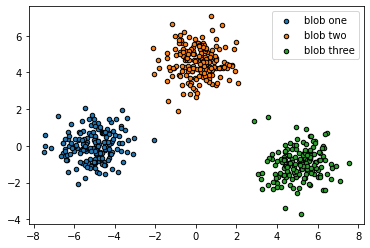

In [9]:
plot_mc_data(X_orig,y_train,["blob one", "blob two", "blob three"], legend=True)
plt.show()

In [10]:
# show classes in data set
print(f"unique classes {np.unique(y_train)}")
# show shapes of our dataset
print(f"shape of X_orig: {X_orig.shape}, shape of y_train: {y_train.shape}")

unique classes [0 1 2]
shape of X_orig: (500, 2), shape of y_train: (500,)


<a name='ova'></a>
##  One Vs All Implementation

We'll implement the OVA algorithm in three step.
- create and train three 'models'. Each trained to select one of the three classes.
- create a routine that will use the models to make predictions and select the best answer.
- plot the decision boundary using the prediction routine.

### Step 1: Create and Train 3 models.
The steps involved will be familiar from past labs utilizing gradient descent. For each class:
- extend the data set with a column of ones to account for $w_0$ (this is provided)
- create `w_init`, initial values from the parameters. We have 3 parameters.
- call gradient descent. alpha=1e-2 and num_iters=1000 works well. This returns $w$ and Cost history. We won't need cost history here. $w$ is our model which we will store in an array.
- call predict with the training data and our model ($w$) to see how good our model is. Note, predict expects the original, non-extended examples (`X_orig`).

Below there is a for loop over each of the classes. 
- creates an target array with the current class set to one and all others set to zero.
     - `yc = (y_train==classes[i]) + 0`
- plots this interpretation of the data
- your code
- plots the predicted values
Replace `None` with your code.

<details>
  <summary><font size="2" color="darkgreen"><b>Hints</b></font></summary>

```
classes=[0,1,2]
m,n = X_orig.shape
# extend the data with a column of ones
X_train = np.hstack([np.ones((m,1)), X_orig])
# storage for our models (w), one column per class
W_models = np.zeros((n+1,len(classes)))   

plt.figure(figsize=(14, 14))             
for i in classes:
    ax = plt.subplot(3,2, 2*i + 1)
    yc = (y_train==classes[i]) + 0
    plot_mc_data(X_orig, yc,legend=True); plt.title(f"Training Classes, class {i}"); 
    ### START CODE HERE ### 
    w_init = np.zeros((3,))   
    W_models[:,i],_ = gradient_descent(X_train, yc, w_init, compute_cost, compute_gradient,
                                       alpha = 1e-2, num_iters=1000) 
    pred =  predict(X_train, W_models[:,i]) 
    ### END CODE HERE ###         
    
    ax = plt.subplot(3,2, 2*i + 2)
    plot_mc_data(X_orig,pred,legend=True); plt.title("Predicted Classes");
plt.show   
```
</details>

Cost at iteration 0: 0.693147
Cost at iteration 0: 0.693147
Cost at iteration 0: 0.693147


<function matplotlib.pyplot.show(close=None, block=None)>

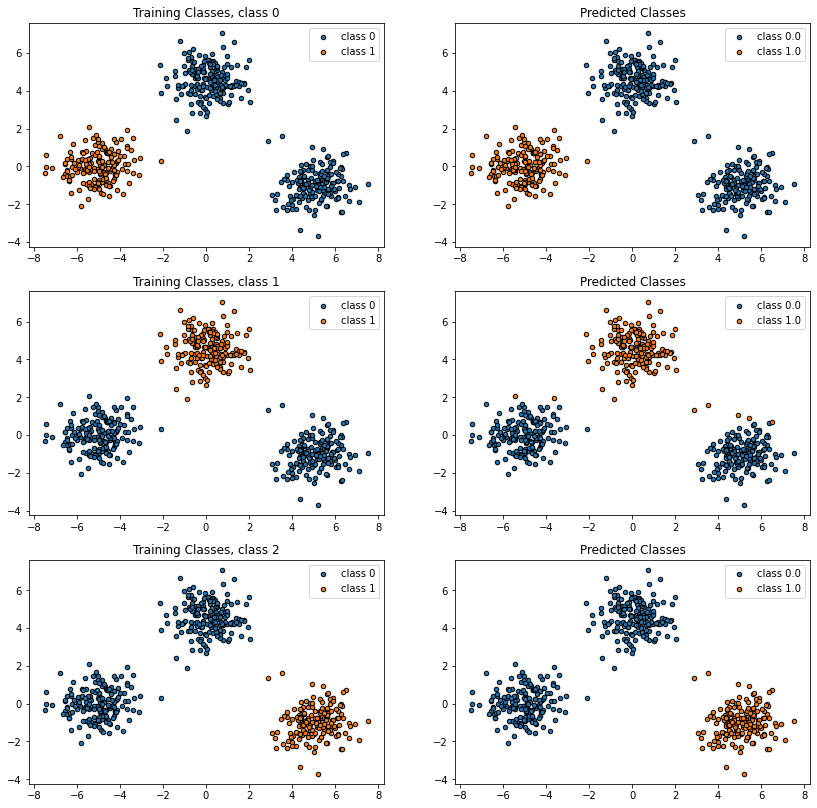

In [11]:
classes=[0,1,2]
m,n = X_orig.shape
# extend the data with a column of ones
X_train = np.hstack([np.ones((m,1)), X_orig])
# storage for our models (w), one column per class
W_models = np.zeros((n+1,len(classes)))   

plt.figure(figsize=(14, 14))             
for i in classes:
    ax = plt.subplot(3,2, 2*i + 1)
    yc = (y_train==classes[i]) + 0
    plot_mc_data(X_orig, yc,legend=True); plt.title(f"Training Classes, class {i}"); 
    ### START CODE HERE ### 
    ### BEGIN SOLUTION ###
    w_init = np.zeros((3,))   ##None
    W_models[:,i],_ = gradient_descent(X_train, yc, w_init, compute_cost, compute_gradient,##None
                                       alpha = 1e-2, num_iters=1000) 
    pred =  predict(X_train, W_models[:,i]) ##None
    ### END SOLUTION ### 
    ### END CODE HERE ###         
    
    ax = plt.subplot(3,2, 2*i + 2)
    plot_mc_data(X_orig,pred,legend=True); plt.title("Predicted Classes");
plt.show

<details>
<summary>
    <b>**Expected Output**:</b>
</summary>

 ![asdf](./figures/C1W3_trainvpredict.PNG)

Now that we have trained our 3 models we will write a routine to select the best prediction. 
-Step 1: Given $X$ and matrix $W$, perform a prediction resulting in three predictions. This can be one line if vectorised. ![pic](./figures/C1W3_XW.PNG)  
-Step 2: use `np.argmax()` to return the **class** of the prediction with the highest value. Note that class is one of [0,1,2] and the index returned by `np.argmax` is, conveniently also [0,1,2].

<details>
  <summary><font size="2" color="darkgreen"><b>Hints</b></font></summary>

```
def predict_mc(X,W):
    """
    Adds a column of ones to X and computes n predictions and selects the best.
    Args:
      X : (array_like Shape (m,n)) feature values used in prediction.  
      W : (array_like Shape (n,c)) Matrix of parameter. Each column represents 1 model.c models
    Returns
      sclass: (array_like Shape (m,1)) The selected class the values belong in. Values 0 to c.
    """
    X = np.hstack([np.ones((len(X),1)), X])
    ### START CODE HERE ### 
    P = X @ W
    sclass = P.argmax(axis=1)
    ### END CODE HERE ### 

    return(sclass)  
```
</details>

In [12]:
def predict_mc(X,W):
    """
    Adds a column of ones to X and computes n predictions and selects the best.
    Args:
      X : (array_like Shape (m,n)) feature values used in prediction.  
      W : (array_like Shape (n,c)) Matrix of parameter. Each column represents 1 model.c models
    Returns
      sclass: (array_like Shape (m,1)) The selected class the values belong in. Values 0 to c.
    """
    X = np.hstack([np.ones((len(X),1)), X])
    ### START CODE HERE ### 
    ### BEGIN SOLUTION ###  
    P = X @ W
    sclass = P.argmax(axis=1)
    ### END SOLUTION ###  
    ### END CODE HERE ### 

    return(sclass)

Now that we can make a prediction for any point, we can now produce a plot with the decision boundary shown.

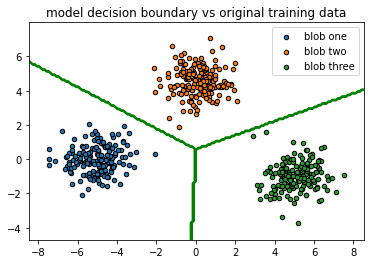

In [13]:
#plot the decison boundary. Pass in our models - the w's assocated with each model
plot_mc_decision_boundary(X_orig,3, W_models)
plt.title("model decision boundary vs original training data")

#add the original data to the decison bounaryd
plot_mc_data(X_orig,y_train,["blob one", "blob two", "blob three"], legend=True)
plt.show()

<details>
<summary>
    <b>**Expected Output**:</b>
</summary>

![sdf](./figures/C1W3_boundary.PNG)

There you are! You have now build a Multi-Class classifier.

Lets try another case. We'll just move the blobs around a bit:
## Second Test Case

In [14]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1], [5, -1]]
X_orig, y_train = make_blobs(n_samples=500, centers=centers, cluster_std=1.2,random_state=40)


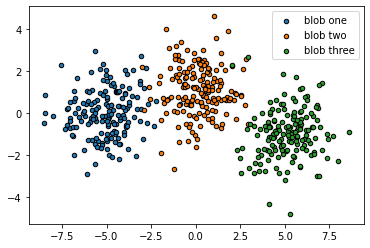

In [15]:
plot_mc_data(X_orig,y_train,["blob one", "blob two", "blob three"], legend=True)
plt.show()

In [16]:
# show classes in data set
print(f"unique classes {np.unique(y_train)}")
# show shapes of our dataset
print(f"shape of X_orig: {X_orig.shape}, shape of y_train: {y_train.shape}")

unique classes [0 1 2]
shape of X_orig: (500, 2), shape of y_train: (500,)


Examaning the plot above, do you see any potential issues with our current approach?

Piece together the pieces from above, or create subroutines to create a decision boundary diagram like the one in the first example.

<details>
  <summary><font size="2" color="darkgreen"><b>Hints</b></font></summary>

```
classes=[0,1,2]
m,n = X_orig.shape
X_train = np.hstack([np.ones((m,1)), X_orig])
W_models = np.zeros((n+1,len(classes)))   # stores our models
             
for i in classes:
    y_ = (y_train==classes[i]) + 0
    #plot_mc_data(X_orig, y_,legend=True); plt.title("Original Classes"); plt.show()
    w_init = np.zeros((3,))
    W_models[:,i],_ = gradient_descent(X_train, y_, w_init, compute_cost, compute_gradient, 1e-3, 10) 
    pred =  predict(X_train, W_models[:,i])
    #plot_mc_data(X_orig,pred,legend=True); plt.title("Predicted Classes"); plt.show()
    
#plot the decison boundary. Pass in our models - the w's assocated with each model
plot_mc_decision_boundary(X_orig,3, W_models)
plt.title("model decision boundary vs original training data")

#add the original data to the decison boundary
plot_mc_data(X_orig,y_train,["blob one", "blob two", "blob three"], legend=True)
plt.show() 
```
</details>

In [ ]:
#Rewrite code here

<details>
<summary>
    <b>**Expected Output**:</b>
</summary>

![asdf](./figures/C1W3_example2.PNG)
    
We will study logistic regression with polynomial features in the next lab. That will allow us to handle situations where purely linear solutions are not enough.

This notebook made was informed by an example at scikit-learn.org. The author was Tom Dupre la Tour <tom.dupre-la-tour@m4x.org>